In [1]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

**Acquérir les données et créer le Dataframe**

**A) Scrapping :**

Identification des critères de recherches afin d'avoir plus d'informations. Collecter les données nécessaires permettant de prédire le prix futur et la production fututre des tomates.

**B) Description des données:**

Au total, il y a 425 observations et 11 variables qualitatives. Les données sont:

la date le prix moyen au kg le prix minimal le prix maximal la température minimale en °C la température maximale en °C le taux de précipitations en mm l'ensoleillement en min la vitesse du vent en km/h la catégorie de la tomate

**Modèle**

In [2]:
Pop = pd.read_csv("/content/TM.csv")
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7
...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2


In [3]:
Pop['Date'] = pd.to_datetime(Pop['Date'],infer_datetime_format=True) 
Pop = Pop.set_index(['Date'])
Pop

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
Date,,,,,,,
2021-06-21,1.50,0.200,15.7,24.9,3.8,423,61.2
2020-04-12,1.50,0.100,2.9,6.6,0.8,256,65.9
2020-06-11,1.10,0.100,2.3,13.4,0.0,491,46.8
2020-05-11,1.10,0.100,1.8,11.5,0.0,533,32.4
2020-10-30,1.05,0.100,12.6,15.9,0.0,0,40.7
...,...,...,...,...,...,...,...
2013-06-24,1.10,1.120,10.5,19.1,0.0,342,42.6
2013-06-20,1.50,0.075,14.0,21.5,0.8,216,37.1
2013-06-17,1.50,0.020,15.0,27.2,6.8,210,61.1


**Pour le prix**

In [4]:
Prix = Pop['prix moyen au kg']
Prix

Date
2021-06-21    1.50
2020-04-12    1.50
2020-06-11    1.10
2020-05-11    1.10
2020-10-30    1.05
              ... 
2013-06-24    1.10
2013-06-20    1.50
2013-06-17    1.50
2012-09-18    1.10
2012-06-29    1.20
Name: prix moyen au kg, Length: 424, dtype: float64

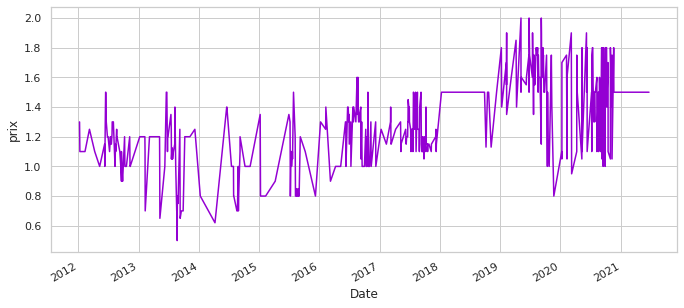

In [5]:
Prix.plot(figsize=(10,5), color = 'darkviolet')
plt.ylabel('prix')
plt.show()

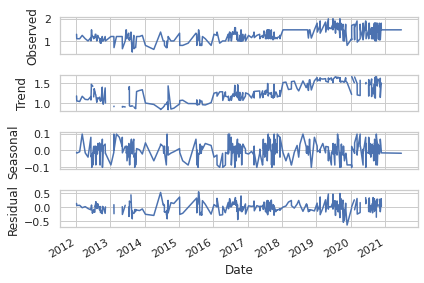

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Prix, freq=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

Text(0.5, 0, 'Année')

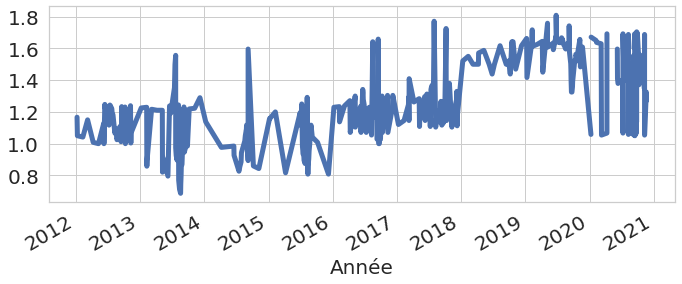

In [7]:
Prix.rolling(12).mean().plot(figsize=(10,4), linewidth=5, fontsize=20)
plt.xlabel('Année', fontsize=20)

Text(0.5, 0, 'Année')

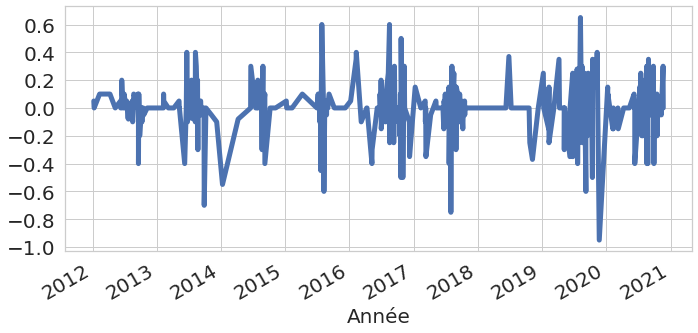

In [8]:
Prix.diff().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Année', fontsize=20)

In [9]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Nb observations'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))


In [10]:
check_stationarity(Prix)

The test statistic: -3.514148
p-value: 0.007631
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


In [11]:
ts_temp_log = np.log(Prix)
ts_temp_log

Date
2021-06-21    0.405465
2020-04-12    0.405465
2020-06-11    0.095310
2020-05-11    0.095310
2020-10-30    0.048790
                ...   
2013-06-24    0.095310
2013-06-20    0.405465
2013-06-17    0.405465
2012-09-18    0.095310
2012-06-29    0.182322
Name: prix moyen au kg, Length: 424, dtype: float64

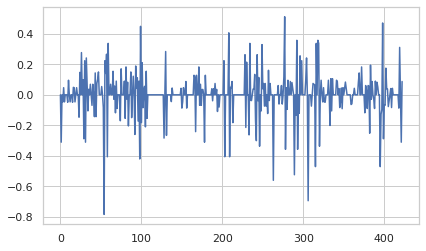

In [12]:
ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [13]:
check_stationarity(ts_temp_log_diff)

The test statistic: -8.529659
p-value: 0.000000
Critical Values:
1%: -3.446
5%: -2.869
10%: -2.571


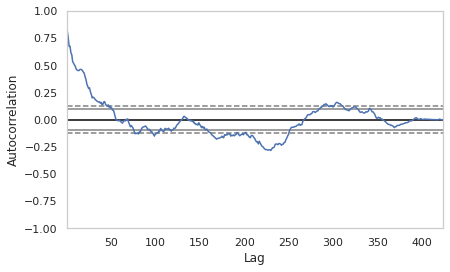

In [14]:
pd.plotting.autocorrelation_plot(Prix)

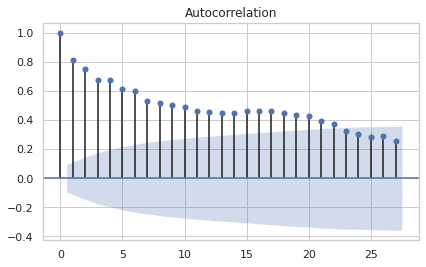

In [15]:
plot_acf(Prix)
plt.show()

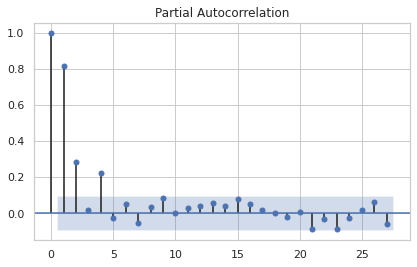

In [16]:
plot_pacf(Prix)
plt.show()

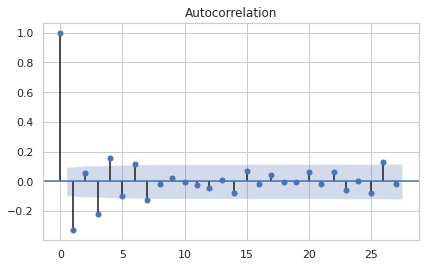

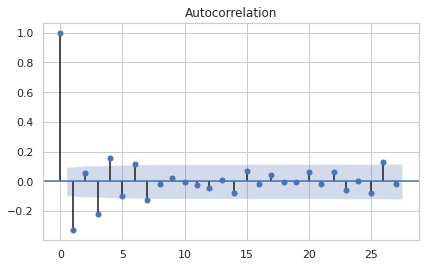

In [17]:
plot_acf(ts_temp_log_diff)

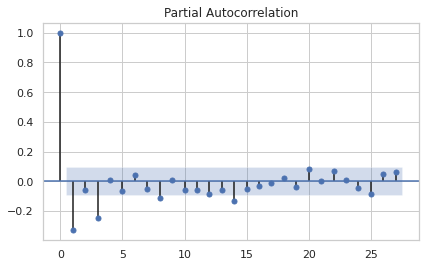

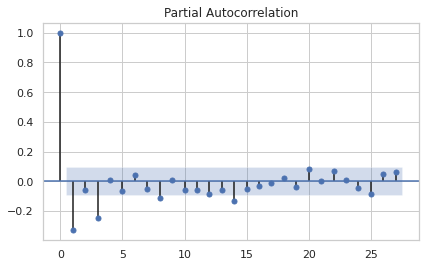

In [18]:
plot_pacf(ts_temp_log_diff)

In [19]:
mod = ARIMA(Prix,order=(1,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:       prix moyen au kg   No. Observations:                  424
Model:                     ARMA(1, 3)   Log Likelihood                 177.382
Method:                       css-mle   S.D. of innovations              0.159
Date:                Fri, 27 Aug 2021   AIC                           -342.765
Time:                        07:42:52   BIC                           -318.467
Sample:                             0   HQIC                          -333.165
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2657      0.078     16.223      0.000       1.113       1.419
ar.L1.prix moyen au kg     0.9576      0.019     51.454      0.000       0.921       0.994
ma.L

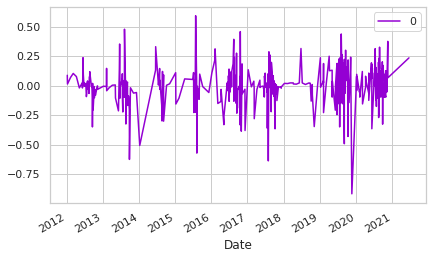

In [20]:
residuals = pd.DataFrame(results.resid)
residuals.plot(color = 'darkviolet')

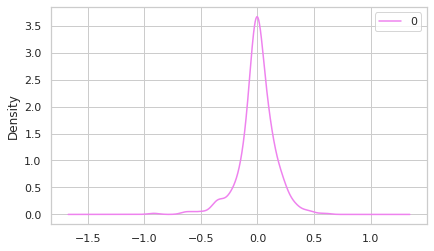

In [21]:
residuals.plot(kind='kde', color = 'violet')

In [22]:
residuals.describe()

,0
count,424.000000
mean,-0.000685
std,0.159498
min,-0.917711
25%,-0.057848
50%,-0.004751
75%,0.078762
max,0.591226


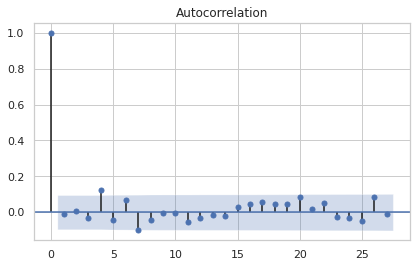

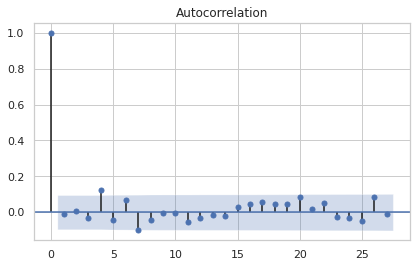

In [23]:
plot_acf(residuals)

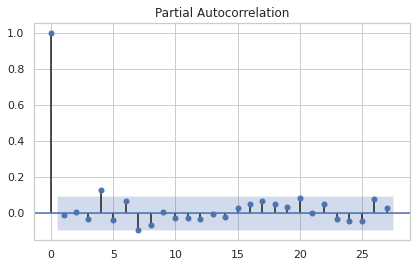

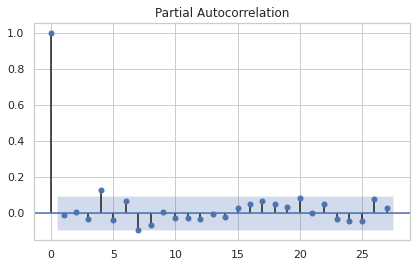

In [24]:
plot_pacf(residuals)

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

R2P = r2_score(Prix, results.predict())
print(R2P)

rmseP =sqrt(mean_squared_error(Prix, results.predict()))
print(rmseP)

0.693812167330573
0.15931166961040413


In [26]:
mean_absolute_error(Prix, results.predict())

0.10696652747986415

**Prédiction du prix des tomates dans 7 jours**

In [27]:
n=7
forecast,err,ci = results.forecast(steps= n, alpha = 0.05)
df_forecast = pd.DataFrame({'Prix dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast

,Prix dans 7 jours
2021-06-22,1.176850
2021-06-23,1.237643
2021-06-24,1.235403
2021-06-25,1.236687
2021-06-26,1.237916
2021-06-27,1.239093
2021-06-28,1.240220


D'après ce dataframe, on en déduit que le prix dans 7 jours aura tendance à augmenter. Cependant, par rapport à au 21/06/2021, le prix a tendance à diminuer

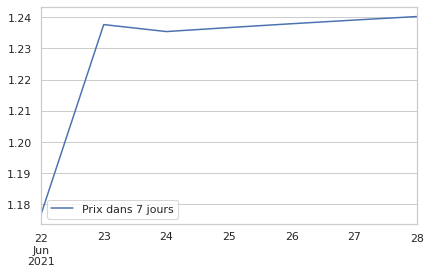

In [28]:
df_forecast.plot()

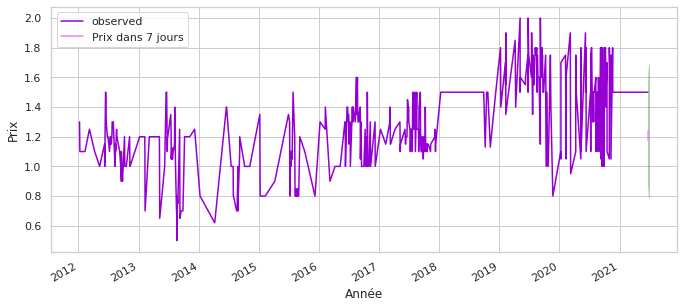

In [29]:
ax = Prix.plot(label='observed', figsize=(10,5), color = 'darkviolet')
df_forecast.plot(ax=ax,label='Forecast',color='violet')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Prix')

plt.legend()
plt.show()

**Pour la production**

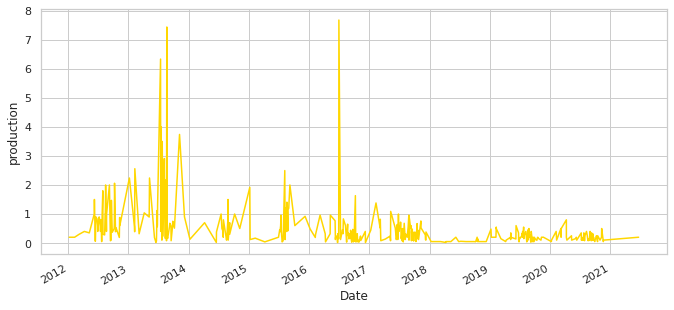

In [30]:
Production = Pop['Production quantité \ntonne(s)']
Production.plot(figsize=(10,5), color = 'gold')
plt.ylabel('production')
plt.show()

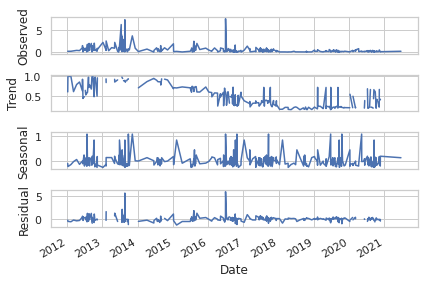

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Production, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

Text(0.5, 0, 'Année')

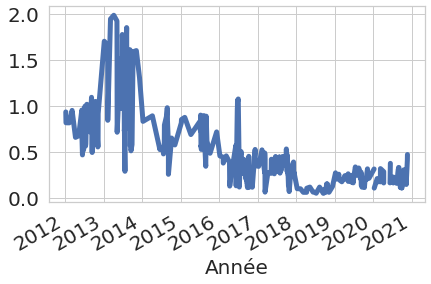

In [32]:
Production.rolling(12).mean().plot(figsize=(6,4), linewidth=5, fontsize=20)
plt.xlabel('Année', fontsize=20)

In [33]:
check_stationarity(Production)

The test statistic: -5.448936
p-value: 0.000003
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


In [34]:
ts_temp_log2 = np.log(Production)
ts_temp_log2

Date
2021-06-21   -1.609438
2020-04-12   -2.302585
2020-06-11   -2.302585
2020-05-11   -2.302585
2020-10-30   -2.302585
                ...   
2013-06-24    0.113329
2013-06-20   -2.590267
2013-06-17   -3.912023
2012-09-18   -1.714798
2012-06-29   -0.916291
Name: Production quantité \ntonne(s), Length: 424, dtype: float64

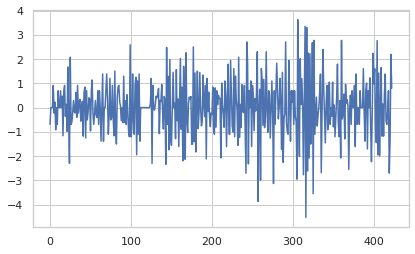

In [35]:
ts_temp_log_diff2 = np.diff(ts_temp_log2)

plt.plot(ts_temp_log_diff2)

In [36]:
check_stationarity(ts_temp_log_diff2)

The test statistic: -7.911705
p-value: 0.000000
Critical Values:
1%: -3.447
5%: -2.869
10%: -2.571


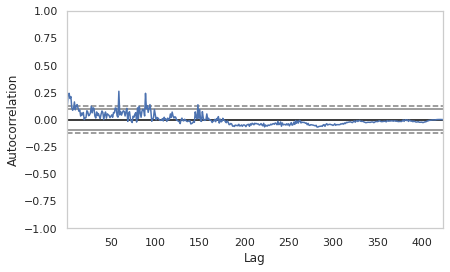

In [37]:
pd.plotting.autocorrelation_plot(Production)

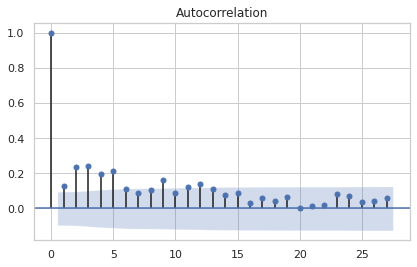

In [38]:
plot_acf(Production)
plt.show()

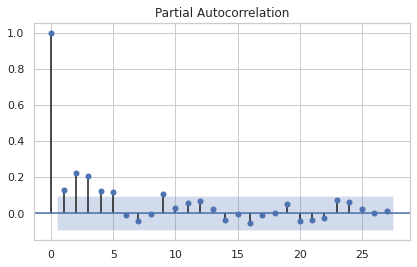

In [39]:
plot_pacf(Production)
plt.show()

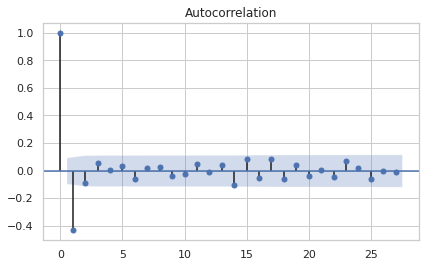

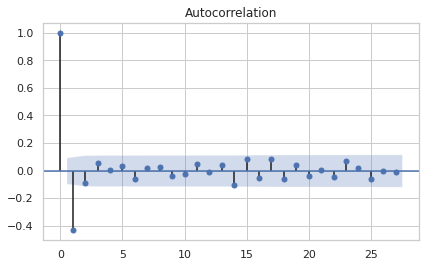

In [40]:
plot_acf(ts_temp_log_diff2)

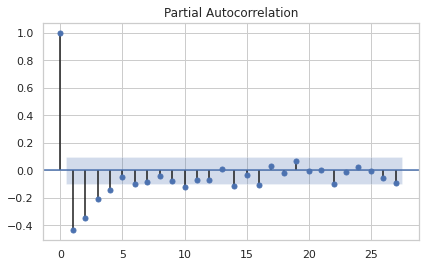

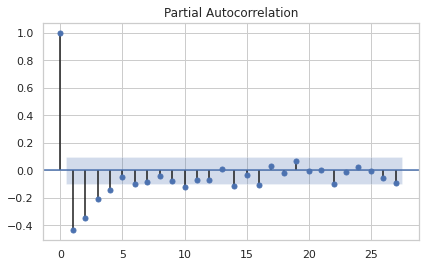

In [41]:
plot_pacf(ts_temp_log_diff2)

In [42]:
mod2 = ARIMA(Production,order=(1,0,3))
results2 = mod2.fit()
print(results2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                    ARMA Model Results                                   
Dep. Variable:     Production quantité 
tonne(s)   No. Observations:                  424
Model:                                ARMA(1, 3)   Log Likelihood                -466.208
Method:                                  css-mle   S.D. of innovations              0.726
Date:                           Fri, 27 Aug 2021   AIC                            944.417
Time:                                   07:43:01   BIC                            968.715
Sample:                                        0   HQIC                           954.017
                                                                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4593      0.082      5.613    

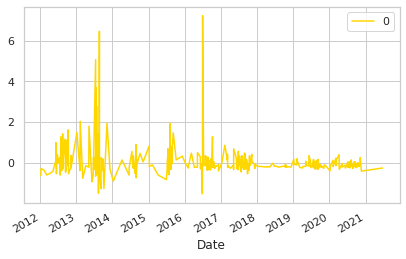

In [43]:
residuals2 = pd.DataFrame(results2.resid)
residuals2.plot(color = 'gold')

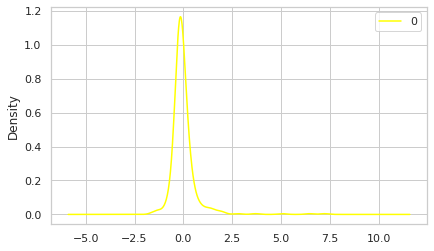

In [44]:
residuals2.plot(kind='kde', color = 'yellow')

In [45]:
residuals2.describe()

,0
count,424.000000
mean,0.001753
std,0.727204
min,-1.526445
25%,-0.240632
50%,-0.147109
75%,0.095094
max,7.217352


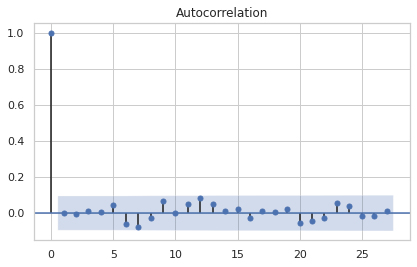

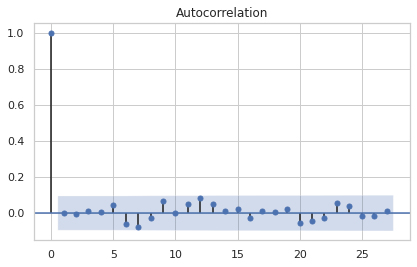

In [46]:
plot_acf(residuals2)

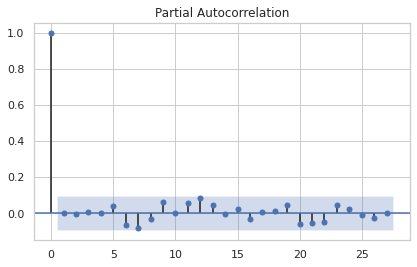

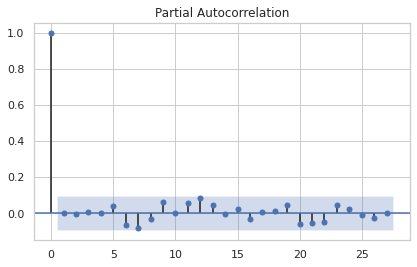

In [47]:
plot_pacf(residuals2)

In [48]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

R2Po = r2_score(Production, results2.predict())
print(R2Po)

rmsePo =sqrt(mean_squared_error(Production, results2.predict()))
print(rmsePo)

0.12357379620497622
0.7263484669197126


In [49]:
mean_absolute_error(Production, results2.predict())

0.36059412026256776

**Prédiction de la production des tomates dans 7 jours**

In [50]:
n=7
forecast,err,ci = results2.forecast(steps= n, alpha = 0.05)
df_forecast2 = pd.DataFrame({'Production dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast2

,Production dans 7 jours
2021-06-22,0.340431
2021-06-23,0.341326
2021-06-24,0.358662
2021-06-25,0.374005
2021-06-26,0.387010
2021-06-27,0.398033
2021-06-28,0.407377


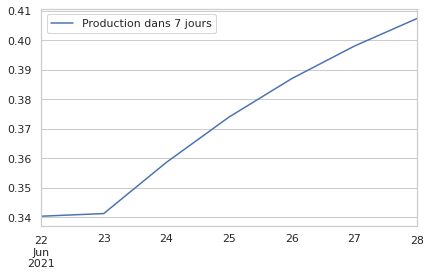

In [51]:
df_forecast2.plot()

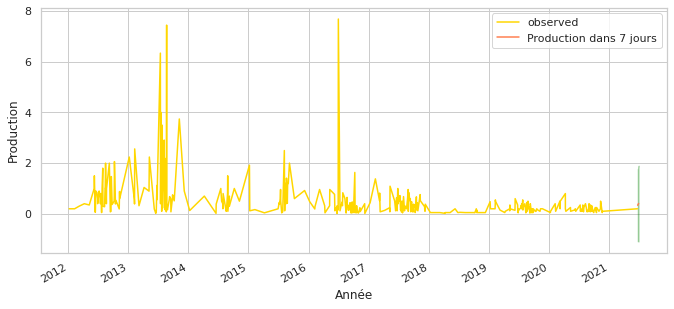

In [52]:
ax = Production.plot(label='observed', figsize=(10,5), color = 'gold')
df_forecast2.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast2.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Production')

plt.legend()
plt.show()

**Prédiction de la météo**

In [53]:
Tm = Pop["Température minimale en °C"]
TM = Pop["Température maximale en °C"]
P = Pop["précipitations en mm"]
E = Pop["Ensoleillement en min"]
V = Pop["Rafales (vitesse du vent) en km/h"]

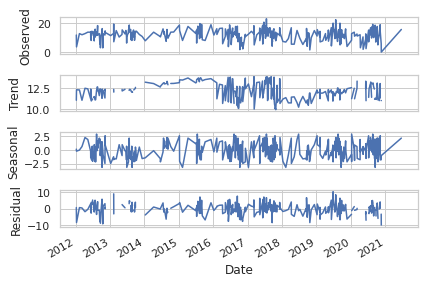

In [54]:
#la température minimale

decomposition = seasonal_decompose(Tm, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [55]:
check_stationarity(Tm)

The test statistic: -6.935589
p-value: 0.000000
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


In [56]:
ts_temp_log = np.log(Tm)
ts_temp_log

Date
2021-06-21    2.753661
2020-04-12    1.064711
2020-06-11    0.832909
2020-05-11    0.587787
2020-10-30    2.533697
                ...   
2013-06-24    2.351375
2013-06-20    2.639057
2013-06-17    2.708050
2012-09-18    2.332144
2012-06-29    2.660260
Name: Température minimale en °C, Length: 424, dtype: float64

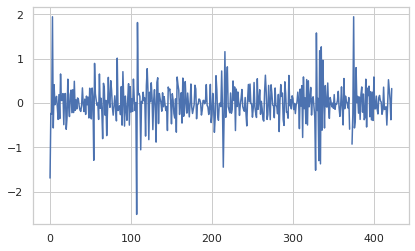

In [57]:
ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [58]:
mod = ARIMA(Tm,order=(2,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                  ARMA Model Results                                  
Dep. Variable:     Température minimale en °C   No. Observations:                  424
Model:                             ARMA(2, 3)   Log Likelihood               -1123.083
Method:                               css-mle   S.D. of innovations              3.419
Date:                        Fri, 27 Aug 2021   AIC                           2260.166
Time:                                07:43:07   BIC                           2288.514
Sample:                                     0   HQIC                          2271.367
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               12.0366      0.471     25.577      0.000      11.114      12.959
a

In [59]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast3 = pd.DataFrame({'température minimale dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast3

,température minimale dans 7 jours
2021-06-22,12.919118
2021-06-23,12.532779
2021-06-24,12.189547
2021-06-25,12.357833
2021-06-26,12.183041
2021-06-27,12.252777
2021-06-28,12.161002


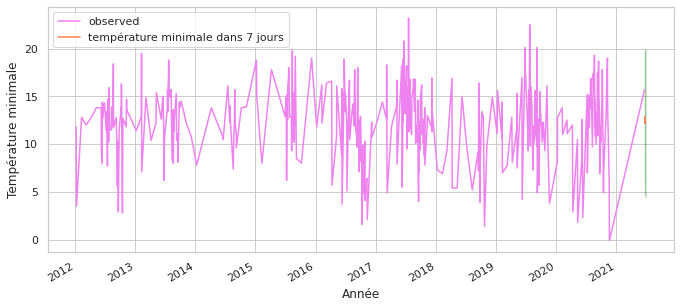

In [60]:
ax = Tm.plot(label='observed', figsize=(10,5), color = 'violet')
df_forecast3.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast3.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Température minimale')

plt.legend()
plt.show()

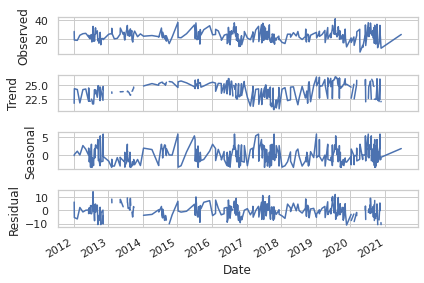

In [61]:
#Température maximale



decomposition = seasonal_decompose(TM, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [62]:
check_stationarity(TM)

The test statistic: -5.363624
p-value: 0.000004
Critical Values:
1%: -3.446
5%: -2.869
10%: -2.570


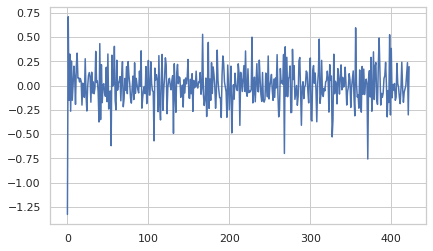

In [63]:
ts_temp_log = np.log(TM)

ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [64]:
mod = ARIMA(TM,order=(2,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                  ARMA Model Results                                  
Dep. Variable:     Température maximale en °C   No. Observations:                  424
Model:                             ARMA(2, 3)   Log Likelihood               -1216.621
Method:                               css-mle   S.D. of innovations              4.262
Date:                        Fri, 27 Aug 2021   AIC                           2447.242
Time:                                07:43:11   BIC                           2475.590
Sample:                                     0   HQIC                          2458.442
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               23.8519      0.843     28.303      0.000      22.200      25.504
a

In [65]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast4 = pd.DataFrame({'température maximale dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast4

,température maximale dans 7 jours
2021-06-22,23.965920
2021-06-23,23.802580
2021-06-24,23.603566
2021-06-25,23.671873
2021-06-26,23.690652
2021-06-27,23.713604
2021-06-28,23.732299


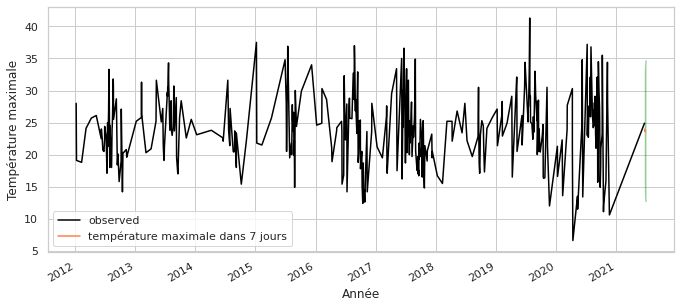

In [66]:
ax = TM.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast4.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast4.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Température maximale')

plt.legend()
plt.show()

In [67]:
# les précipitations

mod = ARIMA(P,order=(2,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               ARMA Model Results                               
Dep. Variable:     précipitations en mm   No. Observations:                  424
Model:                       ARMA(2, 3)   Log Likelihood               -1223.335
Method:                         css-mle   S.D. of innovations              4.313
Date:                  Fri, 27 Aug 2021   AIC                           2460.670
Time:                          07:43:12   BIC                           2489.018
Sample:                               0   HQIC                          2471.870
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.4780      0.239      6.196      0.000       1.010       1.946
ar.L1.précipitations en mm    -0.3553      0.008    -43.543      0.

In [68]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast5 = pd.DataFrame({'précipitations dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast5

,précipitations dans 7 jours
2021-06-22,1.404385
2021-06-23,1.813650
2021-06-24,1.318025
2021-06-25,1.201766
2021-06-26,1.734726
2021-06-27,1.660694
2021-06-28,1.158308


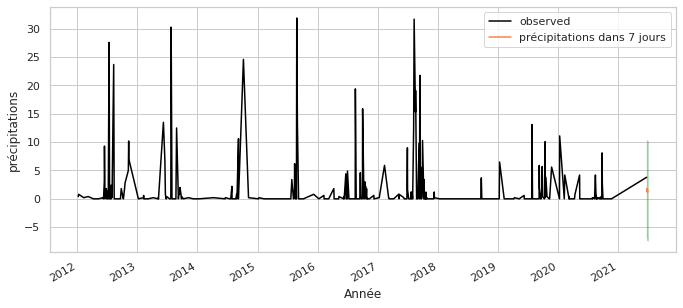

In [69]:
ax = P.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast5.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast5.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('précipitations')

plt.legend()
plt.show()

In [70]:
# l'ensoleillement

mod = ARIMA(E,order=(2,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                ARMA Model Results                               
Dep. Variable:     Ensoleillement en min   No. Observations:                  424
Model:                        ARMA(2, 3)   Log Likelihood               -2921.016
Method:                          css-mle   S.D. of innovations            237.417
Date:                   Fri, 27 Aug 2021   AIC                           5856.032
Time:                           07:43:14   BIC                           5884.380
Sample:                                0   HQIC                          5867.232
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         435.8729     20.447     21.317      0.000     395.798     475.948
ar.L1.Ensoleillement en min     1.8579      0.076     24

In [71]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast6 = pd.DataFrame({'Ensoleillement dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast6

,Ensoleillement dans 7 jours
2021-06-22,281.490696
2021-06-23,307.452289
2021-06-24,316.710794
2021-06-25,327.034383
2021-06-26,338.100013
2021-06-27,349.610808
2021-06-28,361.298331


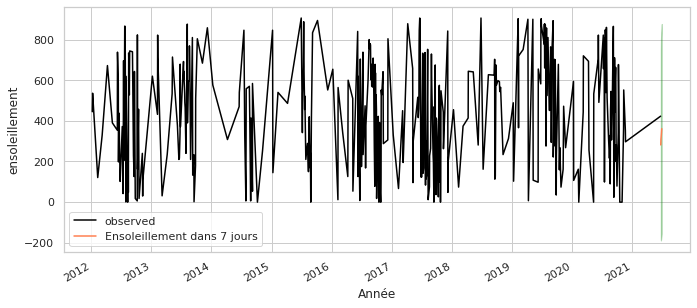

In [72]:
ax = E.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast6.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast6.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('ensoleillement')

plt.legend()
plt.show()

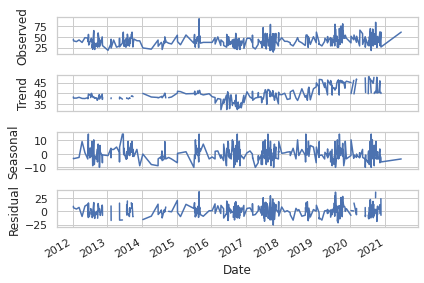

In [73]:
decomposition = seasonal_decompose(V, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [74]:
check_stationarity(V)

The test statistic: -8.852662
p-value: 0.000000
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


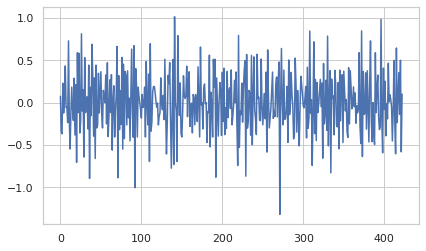

In [75]:
ts_temp_log = np.log(V)

ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [76]:
mod = ARIMA(V,order=(1,0,1))
results = mod.fit()
print(results.summary())

                                      ARMA Model Results                                     
Dep. Variable:     Rafales (vitesse du vent) en km/h   No. Observations:                  424
Model:                                    ARMA(1, 1)   Log Likelihood               -1646.208
Method:                                      css-mle   S.D. of innovations             11.745
Date:                               Fri, 27 Aug 2021   AIC                           3300.415
Time:                                       07:43:17   BIC                           3316.614
Sample:                                            0   HQIC                          3306.815
                                                                                             
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [77]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast7 = pd.DataFrame({'Vitesse du vent dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast7

,Vitesse du vent dans 7 jours
2021-06-22,39.858680
2021-06-23,39.940113
2021-06-24,39.997961
2021-06-25,40.039057
2021-06-26,40.068251
2021-06-27,40.088990
2021-06-28,40.103723


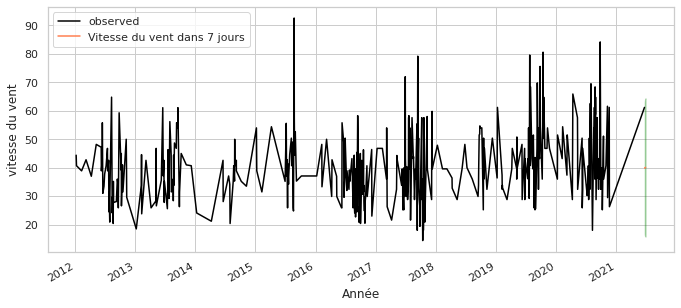

In [78]:
ax = V.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast7.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast7.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('vitesse du vent')

plt.legend()
plt.show()

In [79]:
print(df_forecast)
print(df_forecast2)
print(df_forecast3)
print(df_forecast4)
print(df_forecast5)
print(df_forecast6)
print(df_forecast7)

            Prix dans 7 jours
2021-06-22           1.176850
2021-06-23           1.237643
2021-06-24           1.235403
2021-06-25           1.236687
2021-06-26           1.237916
2021-06-27           1.239093
2021-06-28           1.240220
            Production dans 7 jours
2021-06-22                 0.340431
2021-06-23                 0.341326
2021-06-24                 0.358662
2021-06-25                 0.374005
2021-06-26                 0.387010
2021-06-27                 0.398033
2021-06-28                 0.407377
            température minimale dans 7 jours
2021-06-22                          12.919118
2021-06-23                          12.532779
2021-06-24                          12.189547
2021-06-25                          12.357833
2021-06-26                          12.183041
2021-06-27                          12.252777
2021-06-28                          12.161002
            température maximale dans 7 jours
2021-06-22                          23.965920
2021-06-23  

In [80]:
# tableau récapitulatif des prédictions dans 7 jours. 

RTS={'Prix au kilo des tomates dans 7 jours':[1.177, 1.238, 1.235, 1.237, 1.238, 1.239, 1.240],
     'Production de tomates dans 7 jours' :[0.340, 0.341, 0.351, 0.374, 0.387, 0.398, 0.407],
     'Température minimale dans 7 jours': [12.9, 12.5, 12.2, 12.4, 12.2, 12.3, 12.2],
     'Température maximale dans 7 jours':[24, 23.8, 23.6, 23.7, 23.7, 23.7, 23.7],
     'Précipitations dans 7 jours':[1.4, 1.8, 1.3, 1.2, 1.7, 1.7, 1.2],
     'Ensoleillement dans 7 jours':[281, 307, 317, 327, 338, 350, 361],
     'Vitesse du vent dans 7 jours':[39.9, 39.9, 40, 40, 40, 40, 40.1]}
RTS

{'Ensoleillement dans 7 jours': [281, 307, 317, 327, 338, 350, 361],
 'Prix au kilo des tomates dans 7 jours': [1.177,
  1.238,
  1.235,
  1.237,
  1.238,
  1.239,
  1.24],
 'Production de tomates dans 7 jours': [0.34,
  0.341,
  0.351,
  0.374,
  0.387,
  0.398,
  0.407],
 'Précipitations dans 7 jours': [1.4, 1.8, 1.3, 1.2, 1.7, 1.7, 1.2],
 'Température maximale dans 7 jours': [24, 23.8, 23.6, 23.7, 23.7, 23.7, 23.7],
 'Température minimale dans 7 jours': [12.9,
  12.5,
  12.2,
  12.4,
  12.2,
  12.3,
  12.2],
 'Vitesse du vent dans 7 jours': [39.9, 39.9, 40, 40, 40, 40, 40.1]}

In [81]:
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.177,0.340,12.9,24.0,1.4,281,39.9
2021-06-23,1.238,0.341,12.5,23.8,1.8,307,39.9
2021-06-24,1.235,0.351,12.2,23.6,1.3,317,40.0
2021-06-25,1.237,0.374,12.4,23.7,1.2,327,40.0
2021-06-26,1.238,0.387,12.2,23.7,1.7,338,40.0
2021-06-27,1.239,0.398,12.3,23.7,1.7,350,40.0
2021-06-28,1.240,0.407,12.2,23.7,1.2,361,40.1


**Enregistrement du modèle**

On enregistre le modèle sous forme de joblib pour la prédiction du prix.

In [82]:
import pickle

model = ARIMA(Prix,order=(1,0,3))
results = model.fit()

filename = 'modèle_ARIMA_Prix2.pkl'
pickle.dump(results, open(filename, 'wb'))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [83]:
modèle1 = pickle.load(open(filename, 'rb'))
modèle1

In [84]:
mod2 = ARIMA(Production,order=(1,0,3))
results2 = mod2.fit()

filename2 = 'modèle_ARIMA_Production2.pkl'
pickle.dump(results2, open(filename2, 'wb'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

